# Twitter 2019

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')  # Download the VADER lexicon
import matplotlib.pyplot as plt

import psycopg2
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Extract and organize data

In [2]:
# import data
data = pd.read_csv('Twitter/result20190101-20200101.csv',encoding='ISO-8859-1')


In [3]:
# grab fields of interest
# select the columns wanted and rename them
df_selection = data[['create_at', 'geo_tag.stateName', 'user.id', 'text']]
data = df_selection.rename(columns={
    'create_at': 'Created',
    'geo_tag.stateName': 'State',
    'user.id': 'Owner',
    'text': 'Tweet'
})
data
# gives 10363 rows × 4 columns

,Created,State,Owner,Tweet
0,2019-07-01 02:19:40.0,Virginia,970851646560497664,@MLBStats @Padres @KathyKLTran @LMErdosSCR_APS...
1,2019-07-01 12:37:49.0,Ohio,523889368,@itsJeffTiedrich @realDonaldTrump Fat ass ugly...
2,2019-07-01 16:10:29.0,Ohio,721691818673508353,@ksorbs Make sure Guatemalans and the MSM are ...
3,2019-07-01 17:58:16.0,California,34062187,@AOC worked for a living and did not have a ri...
4,2019-07-01 20:41:59.0,New York,755895422045028352,"@RichardCRogers @JasonOverstreet Well, you're ..."
...,...,...,...,...
10358,2019-03-31 00:52:51.0,Massachusetts,41085886,@RichardDawkins But what about that then layin...
10359,2019-03-31 10:37:11.0,Michigan,148534222,@RichRockNieRich @charliekirk11 @AdamSchiff I ...
10360,2019-03-31 14:49:51.0,Michigan,621132006,#Trump perhaps you ought to actually try & sol...
10361,2019-03-31 17:23:01.0,California,544784730,@TeoTastic73 Yeah - what is his beef with the ...


In [4]:
# convert the states to abbrivations
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Apply the state mapping to convert the state column
data['State'] = data['State'].map(state_mapping)

# Print the updated DataFrame
data

,Created,State,Owner,Tweet
0,2019-07-01 02:19:40.0,VA,970851646560497664,@MLBStats @Padres @KathyKLTran @LMErdosSCR_APS...
1,2019-07-01 12:37:49.0,OH,523889368,@itsJeffTiedrich @realDonaldTrump Fat ass ugly...
2,2019-07-01 16:10:29.0,OH,721691818673508353,@ksorbs Make sure Guatemalans and the MSM are ...
3,2019-07-01 17:58:16.0,CA,34062187,@AOC worked for a living and did not have a ri...
4,2019-07-01 20:41:59.0,NY,755895422045028352,"@RichardCRogers @JasonOverstreet Well, you're ..."
...,...,...,...,...
10358,2019-03-31 00:52:51.0,MA,41085886,@RichardDawkins But what about that then layin...
10359,2019-03-31 10:37:11.0,MI,148534222,@RichRockNieRich @charliekirk11 @AdamSchiff I ...
10360,2019-03-31 14:49:51.0,MI,621132006,#Trump perhaps you ought to actually try & sol...
10361,2019-03-31 17:23:01.0,CA,544784730,@TeoTastic73 Yeah - what is his beef with the ...


In [5]:
# add year and office columns
data['Year'] = 2019
# Arrange columns: Move the Year and Office columns to the front
new_cols = ['Year', 'Created', 'State', 'Owner', 'Tweet']
data_2019 = data.reindex(columns=new_cols)
data_2019
# gives 10363 rows × 5 columns

,Year,Created,State,Owner,Tweet
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,@MLBStats @Padres @KathyKLTran @LMErdosSCR_APS...
1,2019,2019-07-01 12:37:49.0,OH,523889368,@itsJeffTiedrich @realDonaldTrump Fat ass ugly...
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,@ksorbs Make sure Guatemalans and the MSM are ...
3,2019,2019-07-01 17:58:16.0,CA,34062187,@AOC worked for a living and did not have a ri...
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,"@RichardCRogers @JasonOverstreet Well, you're ..."
...,...,...,...,...,...
10358,2019,2019-03-31 00:52:51.0,MA,41085886,@RichardDawkins But what about that then layin...
10359,2019,2019-03-31 10:37:11.0,MI,148534222,@RichRockNieRich @charliekirk11 @AdamSchiff I ...
10360,2019,2019-03-31 14:49:51.0,MI,621132006,#Trump perhaps you ought to actually try & sol...
10361,2019,2019-03-31 17:23:01.0,CA,544784730,@TeoTastic73 Yeah - what is his beef with the ...


In [6]:
# Check for duplicate rows
duplicate_rows = data_2019.duplicated()

# Print the duplicate rows
print(data_2019[duplicate_rows])

       Year                Created State                Owner   
297    2019  2019-07-01 16:23:03.0    GA   876544627771363329  \
299    2019  2019-07-01 17:58:16.0    CA             34062187   
303    2019  2019-07-01 23:40:31.0    NY             24284521   
327    2019  2019-07-03 08:11:31.0    CO  1130544239366901765   
337    2019  2019-07-03 20:05:54.0    GA   780189904735236096   
...     ...                    ...   ...                  ...   
10276  2019  2019-01-24 19:48:57.0    MN             18606670   
10304  2019  2019-01-26 20:24:10.0    VA             22855302   
10310  2019  2019-01-27 02:24:59.0    OH            700100198   
10327  2019  2019-01-29 11:19:12.0    FL           1360156843   
10359  2019  2019-03-31 10:37:11.0    MI            148534222   

                                                   Tweet  
297    @Hotscot9 @KimKeister1 Im glad that he stands...  
299    @AOC worked for a living and did not have a ri...  
303    @Fernandez4NY, member of @NYSA_Majo

In [7]:
# Remove duplicate rows
data_2019 = data_2019.drop_duplicates()

# Print the DataFrame without duplicates
data_2019
# gives 12010 rows × 5 columns

,Year,Created,State,Owner,Tweet
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,@MLBStats @Padres @KathyKLTran @LMErdosSCR_APS...
1,2019,2019-07-01 12:37:49.0,OH,523889368,@itsJeffTiedrich @realDonaldTrump Fat ass ugly...
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,@ksorbs Make sure Guatemalans and the MSM are ...
3,2019,2019-07-01 17:58:16.0,CA,34062187,@AOC worked for a living and did not have a ri...
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,"@RichardCRogers @JasonOverstreet Well, you're ..."
...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,Nothing helps me give up my @Starbucks habit l...
10358,2019,2019-03-31 00:52:51.0,MA,41085886,@RichardDawkins But what about that then layin...
10360,2019,2019-03-31 14:49:51.0,MI,621132006,#Trump perhaps you ought to actually try & sol...
10361,2019,2019-03-31 17:23:01.0,CA,544784730,@TeoTastic73 Yeah - what is his beef with the ...


# Clean and process data

In [8]:
def trim_length(text):
    '''
    This method removes the repeating characters that are repeated more than 2 times
    '''
    pat = re.compile(r"(.)\1{2,}")
    return pat.sub(r"\1\1", text)

def word_correct(myStr):
    '''
    This method accepts a string and removes the meta characters from it
    '''
    myStr = str(myStr)
    pat = re.compile(r'[^a-zA-Z1-9]+')
    corrected_str = ''
    splits = myStr.split()
    for word in splits:
        word = word.strip()
        word = re.sub(pat, '', word).lower()
        word = trim_length(word)
        corrected_str = corrected_str+word+' '
    corrected_str = corrected_str.strip()
    return corrected_str

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
    myStr = str(myStr)
    lemmatizer = WordNetLemmatizer()
    lst_word = nltk.word_tokenize(myStr)
    final_str=''
    for word in lst_word:
        word = lemmatizer.lemmatize(word, get_pos(word))
        final_str = final_str+word+' '

    final_str = final_str.strip()
    return final_str

data_2019['Tweet'] = data_2019['Tweet'].apply(lambda i:word_correct(i))
data_2019['Tweet'] = data_2019['Tweet'].apply(lambda i:lemmatize_word(i))
print('Done')

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\72231921.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019['Tweet'] = data_2019['Tweet'].apply(lambda i:word_correct(i))


Done


C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\72231921.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019['Tweet'] = data_2019['Tweet'].apply(lambda i:lemmatize_word(i))


In [9]:
# view cleaned data
data_2019

,Year,Created,State,Owner,Tweet
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,mlbstats padre kathykltran lmerdosscraps donbe...
1,2019,2019-07-01 12:37:49.0,OH,523889368,itsjefftiedrich realdonaldtrump fat as ugly ra...
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...
...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,nothing help me give up my starbucks habit lik...
10358,2019,2019-03-31 00:52:51.0,MA,41085886,richarddawkins but what about that then lay an...
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...


# Abortion Tweets

In [10]:
def extract_abortion_text(df):
    df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)
    return df

abortion_tweet_2019 = extract_abortion_text(data_2019)
abortion_tweet_2019

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\467476813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,mlbstats padre kathykltran lmerdosscraps donbe...,NaN
1,2019,2019-07-01 12:37:49.0,OH,523889368,itsjefftiedrich realdonaldtrump fat as ugly ra...,NaN
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate
...,...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,nothing help me give up my starbucks habit lik...,NaN
10358,2019,2019-03-31 00:52:51.0,MA,41085886,richarddawkins but what about that then lay an...,NaN
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN


In [11]:
# remove NaN rows
abortion_2019 = abortion_tweet_2019[abortion_tweet_2019['Abortion'].notna()]
abortion_2019
# gives 1310 rows × 6 columns

,Year,Created,State,Owner,Tweet,Abortion
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right
9,2019,2019-07-02 11:50:29.0,RI,247975042,roseanndemoro ozy danielpmalloy nick4iezos aar...,debate
42,2019,2019-07-07 17:23:17.0,NC,1079230563951747072,if anyone of the democrat presidential candida...,healthcare
45,2019,2019-07-08 11:30:38.0,OH,2889051140,itsjefftiedrich yeess ok im say it right here ...,right
...,...,...,...,...,...,...
10330,2019,2019-01-29 15:47:06.0,ID,536024994,nextrevfnc stevehiltonx you may be right but t...,right
10336,2019,2019-01-29 22:26:32.0,OH,980088018,the new face of the democrat party it good tha...,right
10347,2019,2019-01-31 00:03:17.0,PA,885725533694074884,chefaded lrihendry deathless many promise the ...,abortion
10351,2019,2019-01-31 06:19:57.0,IN,825488436,fairimmigration washtimes trump be right thous...,right


# Feed cleaned data into VADER algo

In [13]:
# only positive and negative sentiments
def get_sentiment_scores(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' and 'compound' columns from the SentimentScores column
    df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})
    
    return df

In [14]:
# Call sentiment function
abortion_sent_2019 = get_sentiment_scores(abortion_2019)
abortion_sent_2019

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,SentimentScores
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,"{'neg': 0.0, 'pos': 0.11}"
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right,"{'neg': 0.131, 'pos': 0.19}"
9,2019,2019-07-02 11:50:29.0,RI,247975042,roseanndemoro ozy danielpmalloy nick4iezos aar...,debate,"{'neg': 0.045, 'pos': 0.094}"
42,2019,2019-07-07 17:23:17.0,NC,1079230563951747072,if anyone of the democrat presidential candida...,healthcare,"{'neg': 0.214, 'pos': 0.114}"
45,2019,2019-07-08 11:30:38.0,OH,2889051140,itsjefftiedrich yeess ok im say it right here ...,right,"{'neg': 0.082, 'pos': 0.219}"
...,...,...,...,...,...,...,...
10330,2019,2019-01-29 15:47:06.0,ID,536024994,nextrevfnc stevehiltonx you may be right but t...,right,"{'neg': 0.0, 'pos': 0.27}"
10336,2019,2019-01-29 22:26:32.0,OH,980088018,the new face of the democrat party it good tha...,right,"{'neg': 0.11, 'pos': 0.173}"
10347,2019,2019-01-31 00:03:17.0,PA,885725533694074884,chefaded lrihendry deathless many promise the ...,abortion,"{'neg': 0.108, 'pos': 0.092}"
10351,2019,2019-01-31 06:19:57.0,IN,825488436,fairimmigration washtimes trump be right thous...,right,"{'neg': 0.114, 'pos': 0.035}"


In [15]:
# show values
abortion_sent_2019['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        71
{'neg': 0.163, 'pos': 0.0}      14
{'neg': 0.0, 'pos': 0.099}       7
{'neg': 0.0, 'pos': 0.126}       6
{'neg': 0.143, 'pos': 0.141}     5
                                ..
{'neg': 0.342, 'pos': 0.0}       1
{'neg': 0.267, 'pos': 0.08}      1
{'neg': 0.205, 'pos': 0.0}       1
{'neg': 0.141, 'pos': 0.026}     1
{'neg': 0.186, 'pos': 0.242}     1
Name: count, Length: 1096, dtype: int64

In [16]:
# Extract the sentiment scores from the 'SentimentScores' column
abortion_sent_2019['Norm_Neg'] = abortion_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2019['Norm_Pos'] = abortion_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2019
# gives 1310 rows × 9 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\887929551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2019['Norm_Neg'] = abortion_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\887929551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2019['Norm_Pos'] = abortion_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg

,Year,Created,State,Owner,Tweet,Abortion,SentimentScores,Norm_Neg,Norm_Pos
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,"{'neg': 0.0, 'pos': 0.11}",0.000000,1.000000
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right,"{'neg': 0.131, 'pos': 0.19}",0.408100,0.591900
9,2019,2019-07-02 11:50:29.0,RI,247975042,roseanndemoro ozy danielpmalloy nick4iezos aar...,debate,"{'neg': 0.045, 'pos': 0.094}",0.323741,0.676259
42,2019,2019-07-07 17:23:17.0,NC,1079230563951747072,if anyone of the democrat presidential candida...,healthcare,"{'neg': 0.214, 'pos': 0.114}",0.652439,0.347561
45,2019,2019-07-08 11:30:38.0,OH,2889051140,itsjefftiedrich yeess ok im say it right here ...,right,"{'neg': 0.082, 'pos': 0.219}",0.272425,0.727575
...,...,...,...,...,...,...,...,...,...
10330,2019,2019-01-29 15:47:06.0,ID,536024994,nextrevfnc stevehiltonx you may be right but t...,right,"{'neg': 0.0, 'pos': 0.27}",0.000000,1.000000
10336,2019,2019-01-29 22:26:32.0,OH,980088018,the new face of the democrat party it good tha...,right,"{'neg': 0.11, 'pos': 0.173}",0.388693,0.611307
10347,2019,2019-01-31 00:03:17.0,PA,885725533694074884,chefaded lrihendry deathless many promise the ...,abortion,"{'neg': 0.108, 'pos': 0.092}",0.540000,0.460000
10351,2019,2019-01-31 06:19:57.0,IN,825488436,fairimmigration washtimes trump be right thous...,right,"{'neg': 0.114, 'pos': 0.035}",0.765101,0.234899


# Race Tweets

In [17]:
def extract_race_text(df):
    df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE) 
    return df

# call race function
# note data_2018 will hold all columns with NaN's
race_tweet_2019 = extract_race_text(data_2019)
race_tweet_2019

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\1785180158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,mlbstats padre kathykltran lmerdosscraps donbe...,NaN,NaN
1,2019,2019-07-01 12:37:49.0,OH,523889368,itsjefftiedrich realdonaldtrump fat as ugly ra...,NaN,NaN
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN
...,...,...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,nothing help me give up my starbucks habit lik...,NaN,NaN
10358,2019,2019-03-31 00:52:51.0,MA,41085886,richarddawkins but what about that then lay an...,NaN,NaN
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN


In [18]:
race_2019 = race_tweet_2019[race_tweet_2019['Race'].notna()]
# Drop Abortion column
race_2019 = race_2019.drop('Abortion', axis=1)
race_2019
# gives 1500 rows × 6 columns

,Year,Created,State,Owner,Tweet,Race
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,white
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,justice
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,social
10,2019,2019-07-02 13:12:41.0,GA,22682918,oodonna lkmoller13 trumpseedeadppl jrubinblogg...,white
11,2019,2019-07-02 16:17:03.0,PA,23941831,i dont agree with kapernecki the betsy ross fl...,racism
...,...,...,...,...,...,...
10337,2019,2019-01-30 00:30:33.0,FL,2367202242,i will unabashedly stand by every freak woman ...,matter
10338,2019,2019-01-30 01:06:15.0,NY,48112717,nopei be flat out troll himconfronting him wit...,white
10345,2019,2019-01-30 21:35:53.0,LA,309939717,oh no give people an equal chance to participa...,racial
10349,2019,2019-01-31 03:58:42.0,CA,291851312,america in general be sit in progressive crazy...,white


In [19]:
# run Vader sentiment on race tweets
race_sent_2019 = get_sentiment_scores(race_2019)
race_sent_2019

,Year,Created,State,Owner,Tweet,Race,SentimentScores
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,white,"{'neg': 0.101, 'pos': 0.109}"
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,justice,"{'neg': 0.131, 'pos': 0.19}"
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,social,"{'neg': 0.06, 'pos': 0.094}"
10,2019,2019-07-02 13:12:41.0,GA,22682918,oodonna lkmoller13 trumpseedeadppl jrubinblogg...,white,"{'neg': 0.0, 'pos': 0.126}"
11,2019,2019-07-02 16:17:03.0,PA,23941831,i dont agree with kapernecki the betsy ross fl...,racism,"{'neg': 0.17, 'pos': 0.018}"
...,...,...,...,...,...,...,...
10337,2019,2019-01-30 00:30:33.0,FL,2367202242,i will unabashedly stand by every freak woman ...,matter,"{'neg': 0.291, 'pos': 0.109}"
10338,2019,2019-01-30 01:06:15.0,NY,48112717,nopei be flat out troll himconfronting him wit...,white,"{'neg': 0.31, 'pos': 0.0}"
10345,2019,2019-01-30 21:35:53.0,LA,309939717,oh no give people an equal chance to participa...,racial,"{'neg': 0.148, 'pos': 0.041}"
10349,2019,2019-01-31 03:58:42.0,CA,291851312,america in general be sit in progressive crazy...,white,"{'neg': 0.176, 'pos': 0.137}"


In [20]:
# count race sentiment scores
race_2019['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        35
{'neg': 0.406, 'pos': 0.0}      13
{'neg': 0.474, 'pos': 0.053}    11
{'neg': 0.414, 'pos': 0.0}       7
{'neg': 0.35, 'pos': 0.0}        7
                                ..
{'neg': 0.21, 'pos': 0.069}      1
{'neg': 0.0, 'pos': 0.079}       1
{'neg': 0.165, 'pos': 0.215}     1
{'neg': 0.042, 'pos': 0.032}     1
{'neg': 0.072, 'pos': 0.16}      1
Name: count, Length: 1289, dtype: int64

In [21]:
# Extract the sentiment scores from the 'SentimentScores' column
race_sent_2019['Norm_Neg'] = race_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2019['Norm_Pos'] = race_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2019.head()

,Year,Created,State,Owner,Tweet,Race,SentimentScores,Norm_Neg,Norm_Pos
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,white,"{'neg': 0.101, 'pos': 0.109}",0.480952,0.519048
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,justice,"{'neg': 0.131, 'pos': 0.19}",0.408100,0.591900
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,social,"{'neg': 0.06, 'pos': 0.094}",0.389610,0.610390
10,2019,2019-07-02 13:12:41.0,GA,22682918,oodonna lkmoller13 trumpseedeadppl jrubinblogg...,white,"{'neg': 0.0, 'pos': 0.126}",0.000000,1.000000
11,2019,2019-07-02 16:17:03.0,PA,23941831,i dont agree with kapernecki the betsy ross fl...,racism,"{'neg': 0.17, 'pos': 0.018}",0.904255,0.095745


# Immigration Tweets

In [22]:
def extract_immigration_text(df):
    df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)
    return df

immigration_tweet_2019 = extract_immigration_text(data_2019)
immigration_tweet_2019

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\126326639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,mlbstats padre kathykltran lmerdosscraps donbe...,NaN,NaN,NaN
1,2019,2019-07-01 12:37:49.0,OH,523889368,itsjefftiedrich realdonaldtrump fat as ugly ra...,NaN,NaN,NaN
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN
...,...,...,...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,nothing help me give up my starbucks habit lik...,NaN,NaN,NaN
10358,2019,2019-03-31 00:52:51.0,MA,41085886,richarddawkins but what about that then lay an...,NaN,NaN,NaN
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN


In [23]:
immigration_2019 = immigration_tweet_2019[immigration_tweet_2019['Immigration'].notna()]
# Drop Abortion and Race columns
immigration_2019 = immigration_2019.drop(['Abortion', 'Race'], axis=1)
immigration_2019
# gives 2493 rows × 6 columns

,Year,Created,State,Owner,Tweet,Immigration
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,border
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,reform
10,2019,2019-07-02 13:12:41.0,GA,22682918,oodonna lkmoller13 trumpseedeadppl jrubinblogg...,border
13,2019,2019-07-02 20:31:54.0,VA,18789002,page88 you know this be an issue of go too lef...,policy
16,2019,2019-07-03 02:08:04.0,TX,418427349,tylerjames2 magisbac cbsnews i have be follow ...,immigration
...,...,...,...,...,...,...
10348,2019,2019-01-31 01:14:20.0,SD,2437340094,therichardlewis god have nothing to do with it...,family
10351,2019,2019-01-31 06:19:57.0,IN,825488436,fairimmigration washtimes trump be right thous...,illegal
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,immigration
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,border


In [24]:
# run Vader sentiment on immigration tweets
immigration_sent_2019 = get_sentiment_scores(immigration_2019)
immigration_sent_2019

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,border,"{'neg': 0.0, 'pos': 0.127}"
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,reform,"{'neg': 0.131, 'pos': 0.19}"
10,2019,2019-07-02 13:12:41.0,GA,22682918,oodonna lkmoller13 trumpseedeadppl jrubinblogg...,border,"{'neg': 0.0, 'pos': 0.126}"
13,2019,2019-07-02 20:31:54.0,VA,18789002,page88 you know this be an issue of go too lef...,policy,"{'neg': 0.087, 'pos': 0.171}"
16,2019,2019-07-03 02:08:04.0,TX,418427349,tylerjames2 magisbac cbsnews i have be follow ...,immigration,"{'neg': 0.0, 'pos': 0.074}"
...,...,...,...,...,...,...,...
10348,2019,2019-01-31 01:14:20.0,SD,2437340094,therichardlewis god have nothing to do with it...,family,"{'neg': 0.21, 'pos': 0.164}"
10351,2019,2019-01-31 06:19:57.0,IN,825488436,fairimmigration washtimes trump be right thous...,illegal,"{'neg': 0.114, 'pos': 0.035}"
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,immigration,"{'neg': 0.0, 'pos': 0.0}"
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,border,"{'neg': 0.181, 'pos': 0.117}"


In [25]:
# count immigration sentiment scores
immigration_sent_2019['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        98
{'neg': 0.162, 'pos': 0.069}    21
{'neg': 0.06, 'pos': 0.191}     18
{'neg': 0.0, 'pos': 0.091}      13
{'neg': 0.069, 'pos': 0.096}    10
                                ..
{'neg': 0.125, 'pos': 0.069}     1
{'neg': 0.193, 'pos': 0.079}     1
{'neg': 0.059, 'pos': 0.131}     1
{'neg': 0.292, 'pos': 0.076}     1
{'neg': 0.054, 'pos': 0.153}     1
Name: count, Length: 1991, dtype: int64

In [26]:
# Extract the sentiment scores from the 'SentimentScores' column
immigration_sent_2019['Norm_Neg'] = immigration_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2019['Norm_Pos'] = immigration_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2019
# gives 2493 rows × 9 columns

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores,Norm_Neg,Norm_Pos
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,border,"{'neg': 0.0, 'pos': 0.127}",0.000000,1.000000
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,reform,"{'neg': 0.131, 'pos': 0.19}",0.408100,0.591900
10,2019,2019-07-02 13:12:41.0,GA,22682918,oodonna lkmoller13 trumpseedeadppl jrubinblogg...,border,"{'neg': 0.0, 'pos': 0.126}",0.000000,1.000000
13,2019,2019-07-02 20:31:54.0,VA,18789002,page88 you know this be an issue of go too lef...,policy,"{'neg': 0.087, 'pos': 0.171}",0.337209,0.662791
16,2019,2019-07-03 02:08:04.0,TX,418427349,tylerjames2 magisbac cbsnews i have be follow ...,immigration,"{'neg': 0.0, 'pos': 0.074}",0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
10348,2019,2019-01-31 01:14:20.0,SD,2437340094,therichardlewis god have nothing to do with it...,family,"{'neg': 0.21, 'pos': 0.164}",0.561497,0.438503
10351,2019,2019-01-31 06:19:57.0,IN,825488436,fairimmigration washtimes trump be right thous...,illegal,"{'neg': 0.114, 'pos': 0.035}",0.765101,0.234899
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,immigration,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,border,"{'neg': 0.181, 'pos': 0.117}",0.607383,0.392617


# Socioeconomic Tweets

In [27]:
def extract_socio_text(df):
    df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)
    return df

socio_tweet_2019 = extract_socio_text(data_2019)
socio_tweet_2019

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\2523795090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,mlbstats padre kathykltran lmerdosscraps donbe...,NaN,NaN,NaN,NaN
1,2019,2019-07-01 12:37:49.0,OH,523889368,itsjefftiedrich realdonaldtrump fat as ugly ra...,NaN,NaN,NaN,NaN
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border,NaN
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN,class
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,nothing help me give up my starbucks habit lik...,NaN,NaN,NaN,NaN
10358,2019,2019-03-31 00:52:51.0,MA,41085886,richarddawkins but what about that then lay an...,NaN,NaN,NaN,NaN
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN,healthcare
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN,class


In [28]:
# drop NaN's
socio_2019 = socio_tweet_2019[socio_tweet_2019['Socio_Eco'].notna()]
# Drop Abortion and Race columns
socio_2019 = socio_2019.drop(['Abortion', 'Race','Immigration'], axis=1)
socio_2019
# gives 1832 rows × 6 columns

,Year,Created,State,Owner,Tweet,Socio_Eco
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,class
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,safety
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,social
12,2019,2019-07-02 18:21:17.0,MO,268156595,richardengel now a green newdeal 93 trillion m...,medicare
13,2019,2019-07-02 20:31:54.0,VA,18789002,page88 you know this be an issue of go too lef...,medicare
...,...,...,...,...,...,...
10343,2019,2019-01-30 18:05:34.0,NV,1033814198461972480,so now the left claim rbg be not dead but in a...,job
10346,2019,2019-01-30 23:12:35.0,AR,1019724767799205888,democrat ran this last election a warrior for ...,middle
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,job
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare


In [29]:
# run Vader sentiment on Socio_eco tweets
socio_sent_2019 = get_sentiment_scores(socio_2019)
socio_sent_2019

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,class,"{'neg': 0.101, 'pos': 0.109}"
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,safety,"{'neg': 0.131, 'pos': 0.19}"
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,social,"{'neg': 0.06, 'pos': 0.094}"
12,2019,2019-07-02 18:21:17.0,MO,268156595,richardengel now a green newdeal 93 trillion m...,medicare,"{'neg': 0.269, 'pos': 0.09}"
13,2019,2019-07-02 20:31:54.0,VA,18789002,page88 you know this be an issue of go too lef...,medicare,"{'neg': 0.087, 'pos': 0.171}"
...,...,...,...,...,...,...,...
10343,2019,2019-01-30 18:05:34.0,NV,1033814198461972480,so now the left claim rbg be not dead but in a...,job,"{'neg': 0.0, 'pos': 0.049}"
10346,2019,2019-01-30 23:12:35.0,AR,1019724767799205888,democrat ran this last election a warrior for ...,middle,"{'neg': 0.054, 'pos': 0.146}"
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,job,"{'neg': 0.181, 'pos': 0.117}"
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,"{'neg': 0.186, 'pos': 0.242}"


In [30]:
# count immigration sentiment scores
socio_sent_2019['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        43
{'neg': 0.163, 'pos': 0.0}      12
{'neg': 0.0, 'pos': 0.167}       7
{'neg': 0.145, 'pos': 0.11}      5
{'neg': 0.0, 'pos': 0.091}       5
                                ..
{'neg': 0.119, 'pos': 0.137}     1
{'neg': 0.223, 'pos': 0.171}     1
{'neg': 0.19, 'pos': 0.057}      1
{'neg': 0.153, 'pos': 0.079}     1
{'neg': 0.186, 'pos': 0.242}     1
Name: count, Length: 1609, dtype: int64

In [31]:
# Extract the sentiment scores from the 'SentimentScores' column
socio_sent_2019['Norm_Neg'] = socio_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2019['Norm_Pos'] = socio_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2019
# gives 1832 rows × 9 columns

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,class,"{'neg': 0.101, 'pos': 0.109}",0.480952,0.519048
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,safety,"{'neg': 0.131, 'pos': 0.19}",0.408100,0.591900
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,social,"{'neg': 0.06, 'pos': 0.094}",0.389610,0.610390
12,2019,2019-07-02 18:21:17.0,MO,268156595,richardengel now a green newdeal 93 trillion m...,medicare,"{'neg': 0.269, 'pos': 0.09}",0.749304,0.250696
13,2019,2019-07-02 20:31:54.0,VA,18789002,page88 you know this be an issue of go too lef...,medicare,"{'neg': 0.087, 'pos': 0.171}",0.337209,0.662791
...,...,...,...,...,...,...,...,...,...
10343,2019,2019-01-30 18:05:34.0,NV,1033814198461972480,so now the left claim rbg be not dead but in a...,job,"{'neg': 0.0, 'pos': 0.049}",0.000000,1.000000
10346,2019,2019-01-30 23:12:35.0,AR,1019724767799205888,democrat ran this last election a warrior for ...,middle,"{'neg': 0.054, 'pos': 0.146}",0.270000,0.730000
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,job,"{'neg': 0.181, 'pos': 0.117}",0.607383,0.392617
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,"{'neg': 0.186, 'pos': 0.242}",0.434579,0.565421


# All Bias groups Visualized

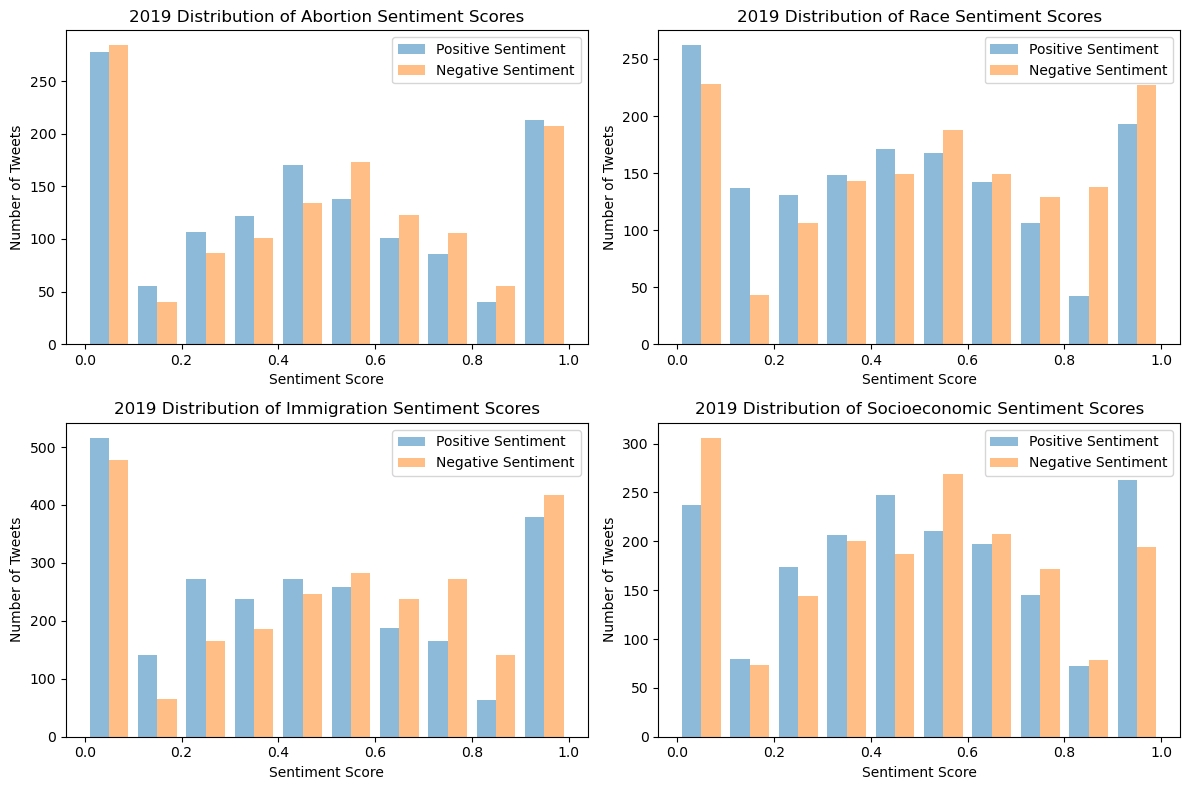

In [32]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for abortion sentiment
axes[0, 0].hist([abortion_sent_2019['Norm_Pos'], abortion_sent_2019['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].set_title('2019 Distribution of Abortion Sentiment Scores')
axes[0, 0].legend()

# Plot histogram for race sentiment
axes[0, 1].hist([race_sent_2019['Norm_Pos'], race_sent_2019['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('2019 Distribution of Race Sentiment Scores')
axes[0, 1].legend()

# Plot histogram for immigration sentiment
axes[1, 0].hist([immigration_sent_2019['Norm_Pos'], immigration_sent_2019['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 0].set_xlabel('Sentiment Score')
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].set_title('2019 Distribution of Immigration Sentiment Scores')
axes[1, 0].legend()

# Plot histogram for socioeconomic sentiment
axes[1, 1].hist([socio_sent_2019['Norm_Pos'], socio_sent_2019['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Number of Tweets')
axes[1, 1].set_title('2019 Distribution of Socioeconomic Sentiment Scores')
axes[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Creating one table with all Bias group tags

In [33]:
data_2019
# gives 9824 rows × 9 columns

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2019,2019-07-01 02:19:40.0,VA,970851646560497664,mlbstats padre kathykltran lmerdosscraps donbe...,NaN,NaN,NaN,NaN
1,2019,2019-07-01 12:37:49.0,OH,523889368,itsjefftiedrich realdonaldtrump fat as ugly ra...,NaN,NaN,NaN,NaN
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border,NaN
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN,class
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10357,2019,2019-01-31 22:03:38.0,NY,17453486,nothing help me give up my starbucks habit lik...,NaN,NaN,NaN,NaN
10358,2019,2019-03-31 00:52:51.0,MA,41085886,richarddawkins but what about that then lay an...,NaN,NaN,NaN,NaN
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN,healthcare
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN,class


In [34]:
# Remove rows with all NaN values in 'Abortion', 'Race', 'Immigration', and 'Socio_Eco' columns
data_2019_filtered = data_2019.dropna(subset=['Abortion', 'Race', 'Immigration', 'Socio_Eco'], how='all')

# Display the filtered DataFrame
print(data_2019_filtered)
# gives [5181 rows x 9 columns]

       Year                Created State               Owner   
2      2019  2019-07-01 16:10:29.0    OH  721691818673508353  \
3      2019  2019-07-01 17:58:16.0    CA            34062187   
4      2019  2019-07-01 20:41:59.0    NY  755895422045028352   
5      2019  2019-07-01 23:40:31.0    NY            24284521   
6      2019  2019-07-02 00:00:37.0    CA  951585690856210433   
...     ...                    ...   ...                 ...   
10352  2019  2019-01-31 14:27:50.0    MA  848959434525167616   
10354  2019  2019-01-31 17:32:00.0    NV          2669719777   
10360  2019  2019-03-31 14:49:51.0    MI           621132006   
10361  2019  2019-03-31 17:23:01.0    CA           544784730   
10362  2019  2019-03-31 21:01:40.0    WA            15596291   

                                                   Tweet    Abortion     Race   
2      ksorbs make sure guatemalan and the msm be awa...         NaN      NaN  \
3      aoc work for a living and do not have a rich f...         NaN 

In [35]:
# run Vader sentiment on All tweets
data_sent_2019 = get_sentiment_scores(data_2019_filtered)
data_sent_2019
# gives 5181 rows × 10 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border,NaN,"{'neg': 0.0, 'pos': 0.127}"
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN,class,"{'neg': 0.101, 'pos': 0.109}"
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN,NaN,"{'neg': 0.0, 'pos': 0.11}"
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right,justice,reform,safety,"{'neg': 0.131, 'pos': 0.19}"
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,NaN,social,NaN,social,"{'neg': 0.06, 'pos': 0.094}"
...,...,...,...,...,...,...,...,...,...,...
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,NaN,NaN,immigration,NaN,"{'neg': 0.0, 'pos': 0.0}"
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,NaN,NaN,border,job,"{'neg': 0.181, 'pos': 0.117}"
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN,healthcare,"{'neg': 0.186, 'pos': 0.242}"
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN,class,"{'neg': 0.0, 'pos': 0.071}"


In [36]:
# Extract the sentiment scores from the 'SentimentScores' column
data_sent_2019['Norm_Neg'] = data_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2019['Norm_Pos'] = data_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2019
# gives 5181 rows × 10 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\3407856195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2019['Norm_Neg'] = data_sent_2019['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\3407856195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2019['Norm_Pos'] = data_sent_2019['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos'])

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border,NaN,"{'neg': 0.0, 'pos': 0.127}",0.000000,1.000000
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN,class,"{'neg': 0.101, 'pos': 0.109}",0.480952,0.519048
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN,NaN,"{'neg': 0.0, 'pos': 0.11}",0.000000,1.000000
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right,justice,reform,safety,"{'neg': 0.131, 'pos': 0.19}",0.408100,0.591900
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,NaN,social,NaN,social,"{'neg': 0.06, 'pos': 0.094}",0.389610,0.610390
...,...,...,...,...,...,...,...,...,...,...,...,...
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,NaN,NaN,immigration,NaN,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,NaN,NaN,border,job,"{'neg': 0.181, 'pos': 0.117}",0.607383,0.392617
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN,healthcare,"{'neg': 0.186, 'pos': 0.242}",0.434579,0.565421
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN,class,"{'neg': 0.0, 'pos': 0.071}",0.000000,1.000000


In [37]:
# This function only gets the compound sentiment
def get_compound_sentiment(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' column from the SentimentScores column
    df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})
    
    return df

In [38]:
# run Vader sentiment on All tweets
data_all_sent_2019 = get_compound_sentiment(data_2019_filtered)
# Drop Sentiment Scores column
data_all_sent_2019 = data_all_sent_2019.drop(['SentimentScores'], axis=1)
data_all_sent_2019
# gives 5181 rows × 12 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\406677615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\406677615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border,NaN,0.000000,1.000000,{'compound': 0.6092}
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN,class,0.480952,0.519048,{'compound': 0.122}
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN,NaN,0.000000,1.000000,{'compound': 0.2732}
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right,justice,reform,safety,0.408100,0.591900,{'compound': 0.3818}
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,NaN,social,NaN,social,0.389610,0.610390,{'compound': 0.2023}
...,...,...,...,...,...,...,...,...,...,...,...,...
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,NaN,NaN,immigration,NaN,0.000000,0.000000,{'compound': 0.0}
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,NaN,NaN,border,job,0.607383,0.392617,{'compound': -0.5499}
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN,healthcare,0.434579,0.565421,{'compound': 0.25}
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN,class,0.000000,1.000000,{'compound': 0.296}


## Final correct data frame to upload to postgresSQL

In [39]:
# Extract to compound value from the dictionary

# Update the "Compound" column
data_all_sent_2019['Compound'] = data_all_sent_2019['Compound'].apply(lambda x: x['compound'])

# Convert the "Compound" column to a numeric data type
data_all_sent_2019['Compound'] = pd.to_numeric(data_all_sent_2019['Compound'])

# Print the updated DataFrame
data_all_sent_2019
# gives 5181 rows × 12 columns

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
2,2019,2019-07-01 16:10:29.0,OH,721691818673508353,ksorbs make sure guatemalan and the msm be awa...,NaN,NaN,border,NaN,0.000000,1.000000,0.6092
3,2019,2019-07-01 17:58:16.0,CA,34062187,aoc work for a living and do not have a rich f...,NaN,white,NaN,class,0.480952,0.519048,0.1220
4,2019,2019-07-01 20:41:59.0,NY,755895422045028352,richardcrogers jasonoverstreet well youre one ...,debate,NaN,NaN,NaN,0.000000,1.000000,0.2732
5,2019,2019-07-01 23:40:31.0,NY,24284521,fernandez4ny member of nysamajority repping ad...,right,justice,reform,safety,0.408100,0.591900,0.3818
6,2019,2019-07-02 00:00:37.0,CA,951585690856210433,beautou msnbc democrat be to busy listen to th...,NaN,social,NaN,social,0.389610,0.610390,0.2023
...,...,...,...,...,...,...,...,...,...,...,...,...
10352,2019,2019-01-31 14:27:50.0,MA,848959434525167616,mayor martywalsh answer question at this morni...,NaN,NaN,immigration,NaN,0.000000,0.000000,0.0000
10354,2019,2019-01-31 17:32:00.0,NV,2669719777,4uconservatives marilynb77 nope but have every...,NaN,NaN,border,job,0.607383,0.392617,-0.5499
10360,2019,2019-03-31 14:49:51.0,MI,621132006,trump perhaps you ought to actually try solve ...,healthcare,NaN,NaN,healthcare,0.434579,0.565421,0.2500
10361,2019,2019-03-31 17:23:01.0,CA,544784730,teotastic73 yeah what be his beef with the acc...,NaN,NaN,NaN,class,0.000000,1.000000,0.2960


## Load Sentiment table into PostGres
data_all_sent_2017: The single table that has all data

In [40]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Create a sqlalchemy engine
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

data_all_sent_2019.to_sql("twitter", engine, if_exists="append", index=False)
print("Twitter table loaded successfully")

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()

Twitter table loaded successfully


## View the data

In [41]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=DATABASE, user=USER, password=PASSWORD, host=HOST, port=PORT)

# Query the table and store the results in a Pandas dataframe
df = pd.read_sql_query("SELECT * FROM twitter", conn)

# Print the dataframe to verify that it contains data
print(df)

# Close the database connection
conn.close()
# gives [3164 rows x 12 columns] for 2016
# [5103 rows x 12 columns] for 2017 appended
# [11304 rows x 12 columns] for 2018 appended
# [16485 rows x 12 columns] for 2019 appended

       Year                Created State               Owner   
0      2016    2016-01-03 10:33:49    TX            14649308  \
1      2016    2016-01-04 16:23:26    NH            88940328   
2      2016     2016-01-05 7:13:04    VA           359716229   
3      2016     2016-01-06 2:52:22    AZ            67238855   
4      2016    2016-01-06 15:27:19    NY            49698134   
...     ...                    ...   ...                 ...   
16480  2019  2019-01-31 14:27:50.0    MA  848959434525167616   
16481  2019  2019-01-31 17:32:00.0    NV          2669719777   
16482  2019  2019-03-31 14:49:51.0    MI           621132006   
16483  2019  2019-03-31 17:23:01.0    CA           544784730   
16484  2019  2019-03-31 21:01:40.0    WA            15596291   

                                                   Tweet    Abortion   Race   
0      deep convos after midtown about black life mat...        None  black  \
1      president bill clinton say this election will ...        None   No

C:\Users\Owner\AppData\Local\Temp\ipykernel_25640\2964356023.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM twitter", conn)
